In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
import jax
import random


import os, sys, argparse
parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron

In [2]:
# Setting up the problem
nqubits = 4 # Last qubit is the output qubit. We're not worrying about it in this setup
L = 3
fourier_basis = 1
ts = jnp.array([0.0, 1.0])

perceptron = Perceptron(nqubits, fourier_basis, basis='pwc')

I0000 00:00:1706285157.105770       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
# Various functions to help simplify the circuit construction

def get_observables(N):
    
    observables = []

    # Coupling operators
    for i in range(N-1):
        observables.append(qml.PauliZ(i) @ qml.PauliZ(i+1))

    # Identity operator
    for i in range(N):
        observables.append(qml.Identity(i))

    return observables

def get_coeffs(params, N):

    coeffs = []

    # Coupling coeffs
    for i in range(N-1):
        coeffs.append((params[0])**2/params[1])

    # Constant coeffs
    for i in range(N):
        coeffs.append(params[1])

    return coeffs

def create_Hamiltonian(params):

    coeffs = get_coeffs(params, nqubits)
    obs = get_observables(nqubits)
    
    # H = qml.dot(coeffs, obs)
    H = qml.Hamiltonian(coeffs, obs)

    return H

def get_Sy(nqubits):

    S_0 = nqubits/2
    c = 0

    for i in range(nqubits):
        c += (1/(2*S_0))*qml.PauliY(wires=i)

    return c

In [4]:
def create_params(L, scale = 0.1):
    
    params = np.array([], requires_grad=True)

    for i in range(L):
        J = scale*np.random.uniform()
        O = 1.0
        theta = scale*np.random.uniform()
        
        params = np.append(params, [J, O, theta], requires_grad=True)
            
    return params

In [5]:
dev = qml.device("default.qubit", wires=nqubits, shots=None)

def U1(params):
    start_index = 0
    num_trotter_steps = 2

    for i in range(L):
        new_params = params[start_index:start_index + 3]
        H = create_Hamiltonian(new_params[0:2])
        qml.evolve(H, num_steps = num_trotter_steps)
        # for j in range(nqubits):
        #     qml.RX(new_params[2], wires=j) # Change params to make sure that theta value changes for each L
        start_index += 3 # Put state_index in again

@qml.qnode(dev)
def circuit(params, a, phi):

    for i in range(nqubits): # Making the initial CSS
        qml.Hadamard(wires=i)

    U1(params)

    # for z in range(nqubits): # Perturbation
    #     qml.RY(phi, wires = z)

    qml.adjoint(U1)(params)

    # expectation_values = [qml.expval(qml.PauliY(wires=i)) for i in range(nqubits)]

    c = get_Sy(nqubits) * a[0]

    return qml.expval(c)

In [6]:
L = 4
params = create_params(L)
phi = np.array([0.001], requires_grad=False)
a = np.array([0.001], requires_grad=False)
circuit(params, a, phi)

tensor(-3.00926554e-36, requires_grad=True)

In [7]:
params

tensor([0.01686686, 1.        , 0.07810264, 0.08207671, 1.        ,
        0.04695861, 0.05885139, 1.        , 0.05346673, 0.06334325,
        1.        , 0.07770641], requires_grad=True)

In [8]:
phi = np.array([0.001], requires_grad=False)
phi

tensor([0.001], requires_grad=False)

/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/drawer/mpldrawer.py:545: UserWarning: Glyph 120023 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL H}) missing from current font.
  bbox = text_obj.get_window_extent(renderer)
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 120023 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL H}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


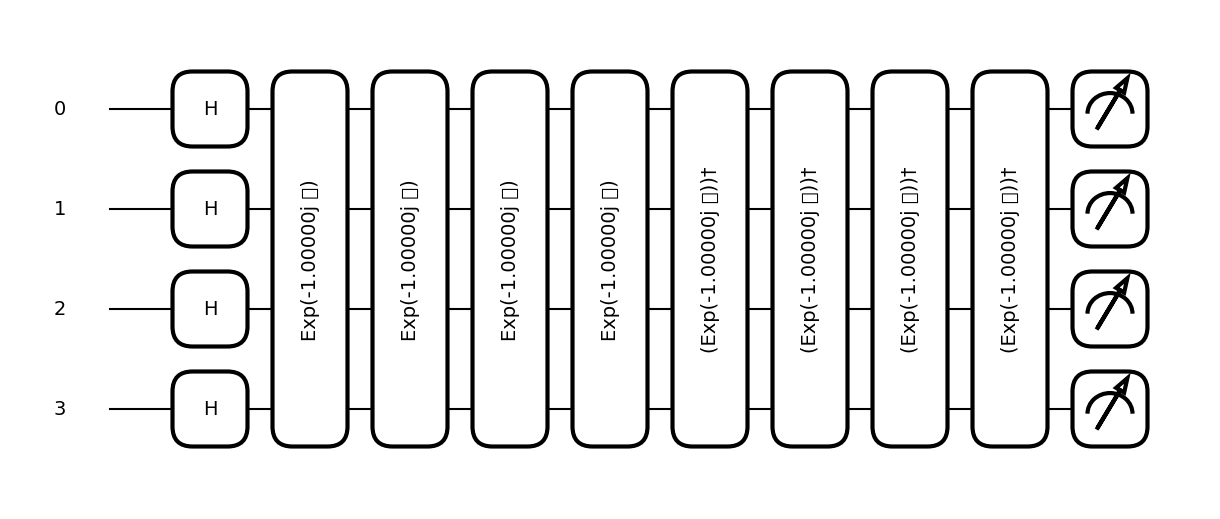

In [15]:
import matplotlib.pyplot as plt
# qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit, decimals=5, style=None)(params, a, phi)
plt.show()

In [16]:
np.set_printoptions(suppress=True, precision=5, linewidth=170)
print(np.round(qml.metric_tensor(circuit, approx="block-diag")(params,a, phi), 8))

[[ 0.00007 -0.       0.       0.      -0.       0.       0.       0.       0.       0.       0.       0.     ]
 [-0.       0.       0.      -0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.      -0.       0.       0.1007  -0.00461  0.       0.      -0.       0.       0.       0.       0.     ]
 [-0.       0.       0.      -0.00461  0.00021  0.      -0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.      -0.       0.       0.01689 -0.00032  0.      -0.       0.       0.     ]
 [ 0.       0.       0.      -0.       0.       0.      -0.00032  0.00001  0.       0.      -0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 

# QNG Calculation Loop

In [ ]:
nqubits = 10 # Last qubit is the output qubit. We're not worrying about it in this setup
L_total = 11
ts = [0.0, 1.0]
phi = np.array([0.001], requires_grad=False)

total_dict = {}

for i in range(1, L_total):
    L = i
    params = create_params(L)
    print(f"~ Beginning calculation of QNG for layer {L}")
    metric_tensor = np.round(qml.metric_tensor(circuit, approx="block-diag")(params, phi), 8)
    qfim = qml.qinfo.quantum_fisher(circuit)(params, phi)
    total_dict[L] = (metric_tensor, qfim)
    print(f"Done calculating QNG for layer {L}")
    

~ Beginning calculation of QNG for layer 1
Done calculating QNG for layer 1
~ Beginning calculation of QNG for layer 2
Done calculating QNG for layer 2
~ Beginning calculation of QNG for layer 3
Done calculating QNG for layer 3
~ Beginning calculation of QNG for layer 4
Done calculating QNG for layer 4
~ Beginning calculation of QNG for layer 5
Done calculating QNG for layer 5
~ Beginning calculation of QNG for layer 6
Done calculating QNG for layer 6
~ Beginning calculation of QNG for layer 7
Done calculating QNG for layer 7
~ Beginning calculation of QNG for layer 8
Done calculating QNG for layer 8
~ Beginning calculation of QNG for layer 9
Done calculating QNG for layer 9
~ Beginning calculation of QNG for layer 10
Done calculating QNG for layer 10


In [ ]:
import pickle

# Specify the file path where you want to save the dictionary
file_path = 'pennylane_qfi_calc.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(total_dict, file)

print(f"Dictionary saved to {file_path}")

Dictionary saved to pennylane_qfi_calc.pkl


# Optimizing loop

In [ ]:
def cost(params, a, phi):
    circuit_output = circuit(params, a, phi)
    mse = np.mean((phi-circuit_output)**2)
    return mse

In [ ]:
L = 1
a = np.array([0.001], requires_grad=True)
init_params = create_params(L)
phi_list = np.array([0.0, 0.1, 0.01, 0.001], requires_grad=False)
cost(init_params, a, phi_list)

tensor(0.00252567, requires_grad=True)

In [ ]:
phi_list

tensor([0.   , 0.1  , 0.01 , 0.001], requires_grad=False)

In [ ]:
print(circuit(params, a, phi_list)) # broadcasting
print(circuit(params, a, phi_list[0]))

[-5.55111512e-21 -7.38905509e-06 -7.39644200e-07 -7.39651581e-08]
-1.1102230246251566e-20


In [ ]:
L = 1
a = np.array([0.001], requires_grad=True)
init_params = create_params(L)
phi_list = np.array([0.0, 0.1, 0.01, 0.001], requires_grad=False)

# circuit(params, a, phi_list)
print(type(phi_list))
print(phi_list)
print(type(phi_list[0]))
print(phi_list[0])

<class 'pennylane.numpy.tensor.tensor'>
[0.    0.1   0.01  0.001]
<class 'pennylane.numpy.tensor.tensor'>
0.0


In [ ]:
phi_list

[tensor([0.   , 0.1  , 0.01 , 0.001], requires_grad=False)]

In [ ]:
# Create a list of length 100
phi_train = []

# Populate the list with NumPy arrays
for _ in range(100):
    x = np.random.uniform(-0.5, 0.5)
    array_with_grad = np.array(x, requires_grad=False)
    phi_train.append(array_with_grad)

In [ ]:
L = 1
a = np.array([0.001], requires_grad=True)
init_params = create_params(L)
phi_list = np.array([0.001, 0.01, 0.1], requires_grad=False)

z = cost(init_params, a, phi_list)

In [ ]:
phi_list = [np.array([0.001], requires_grad=False), np.array([0.01], requires_grad=False)]
for i in phi_list:
        print(i)

[0.001]
[0.01]


In [ ]:
type(phi)

pennylane.numpy.tensor.tensor

In [ ]:
L = 1
nqubits = 10
init_params = create_params(L)
phi = np.array([0.001], requires_grad=False)
a = np.array([0.001], requires_grad=True)
nqubits = 10

eta = 0.1
n_it = 100

# opt = qml.QNGOptimizer(eta, approx='block-diag')
opt = qml.GradientDescentOptimizer(eta)
# opt = qml.AdamOptimizer(stepsize=0.01, beta1=0.9, beta2=0.99)

qng_cost = []

new_params = opt.step_and_cost(cost, init_params, a, phi)

# for _ in range(steps):
#     print(f'Step: {_}')
#     new_params = opt.step(circuit, init_params, phi)
#     qng_cost.append(circuit(new_params))

TypeError: Can't differentiate w.r.t. type <class 'pennylane.ops.qubit.hamiltonian.Hamiltonian'>

In [ ]:
def loss(outputs, values):
    l = [(values-outputs)**2 for i in ]
    return l[0]

In [ ]:
qml.about()

Name: PennyLane
Version: 0.33.1
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /Users/nickg/Documents/RSI/research/code/quantum-perceptron/pennylane-code/venv-pennylane/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Lightning

Platform info:           macOS-13.4.1-x86_64-i386-64bit
Python version:          3.11.5
Numpy version:           1.26.2
Scipy version:           1.11.4
Installed devices:
- default.gaussian (PennyLane-0.33.1)
- default.mixed (PennyLane-0.33.1)
- default.qubit (PennyLane-0.33.1)
- default.qubit.autograd (PennyLane-0.33.1)
- default.qubit.jax (PennyLane-0.33.1)
- default.qubit.legacy (PennyLane-0.33.1)
- default.qubit.tf (PennyLane-0.33.1)
- default.qubit.torch 

In [ ]:
! pip li